# 3D Reconstruction

In [5]:
video_name = 'video11'
input_file_name = f'video/{video_name}.mp4'

## GPLVM Training

         Current function value: 73153.626754
         Iterations: 4
         Function evaluations: 1400
         Gradient evaluations: 99
time: 0.2869279384613037
alpha 0.7385992977670017
beta 0.5612010497957176
gamma 0.056713123591186076
[[-25.01740622 -11.05858155]
 [-24.03136039  -7.27049732]
 [ 44.97702789 -11.32188702]
 [  1.61614185  18.10758359]
 [  2.45555086  11.54379409]]


c:\ProgramData\anaconda3\envs\python310\lib\site-packages\scipy\optimize\_optimize.py:1698: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, **opts)


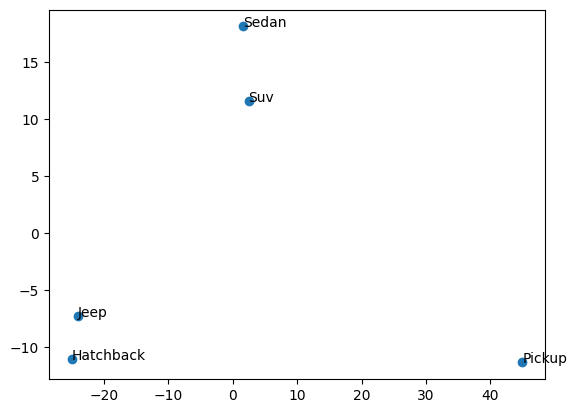

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mygplvm.reconstruction import Reconstruction

sdfs = []
sdf_names = ['Hatchback', 'Jeep', 'Pickup', 'Sedan', 'Suv']
voxel_resolution = 64
dct_resolution = 25
for name in sdf_names:
    sdfs.append(np.load(f'./mygplvm/objs3/{name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}.npy'))

rec = Reconstruction(voxel_resolution=voxel_resolution, dct_resolution=dct_resolution)
print(rec.fit_from_sdf(sdfs=sdfs))

# Scatter plot latent variable
fig, ax = plt.subplots()
ax.scatter(rec.gplvm.X[:, 0], rec.gplvm.X[:, 1])
for i, txt in enumerate(sdf_names):
    ax.annotate(txt, (rec.gplvm.X[i, 0], rec.gplvm.X[i, 1]))

In [24]:
import math
from math import sin, cos

car_tmesh = rec.reconstruct_from_x([-4, 13])
car_tmesh.apply_transform([
    [cos(math.radians(-90))  , 0, sin(math.radians(-90))  , 0],
    [0                      , 1, 0                      , 0],
    [-sin(math.radians(-90)) , 0, cos(math.radians(-90))  , 0],
    [0                      , 0, 0                      , 1]
])
car_tmesh.show()

## GPLVM Car Image

In [4]:
import cv2
import numpy as np
from mygplvm.reconstruction3 import Reconstruction3

car_image = cv2.imread('images/car4.jpg')
rec3 = Reconstruction3(rec.gplvm, voxel_resolution, dct_resolution)
car_mesh = rec3.predict(car_image, np.deg2rad(-90))
car_mesh.show()


0: 448x640 1 car, 525.4ms
Speed: 3.6ms preprocess, 525.4ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)


## GPLVM Video Reconstruction

In [12]:
from mygplvm.reconstruction3 import Reconstruction3

rec3 = Reconstruction3(rec.gplvm, voxel_resolution, dct_resolution)

import pyrender
import matplotlib.pyplot as plt
from math import cos, sin, pi, atan
import json
import cv2
import pyvista as pv
import trimesh
import numpy as np

generic_mesh = rec.reconstruct_from_x([  2.45555086,  11.54379409])

lane_tmesh = trimesh.load('mygplvm/objs3/Lane.obj')
lane_tmesh.visual.vertex_colors = [0, 255, 255, 255]
lane_pymesh = pyrender.Mesh.from_trimesh(lane_tmesh, smooth=False)

output_file_name = f'output/{video_name}_reconstructed.mp4'

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
fps = int(30)
width, height = (
    int(1280),
    int(720)
)
cap = cv2.VideoCapture(input_file_name)
out = cv2.VideoWriter()
out.open(output_file_name, fourcc, fps, (width, height), True)

with open(f'output/{video_name}_states.json') as f:
    state_rotations = json.load(f)['states']
with open(f'output/{video_name}_lanes.json') as f:
    lanes = json.load(f)['lanes']

plane_dimension = [600, 0.01, 3000]
plane_tmesh = trimesh.creation.box(extents=plane_dimension)
plane_tmesh.visual.face_colors = [240, 240, 240, 255]
plane_pymesh = pyrender.Mesh.from_trimesh(plane_tmesh, smooth=False)
# plane_dimension = [70, 0.01, 2000]
# planes = [trimesh.creation.box(extents=plane_dimension) for i in range(11)]
# for i, plane in enumerate(planes):
#     abs_offset = abs(i - len(planes)//2)
#     plane.visual.face_colors = [75 + 15*abs_offset, 75 + 15*abs_offset, 75 + 15*abs_offset, 255]

r = pyrender.OffscreenRenderer(1280, 720)
try:
    proc_frames = 0
    while proc_frames < len(state_rotations):
        ret, frame = cap.read()
        if not ret:
            break
        if proc_frames == 1:
            break
        
        state = state_rotations[proc_frames]
        frame_lanes = lanes[proc_frames]
        scene = pyrender.Scene(ambient_light=[0.8, 0.8, 0.8], bg_color=[50, 50, 50])
        state_multiplier = 15
        state_x_multiplier = 30
        state_z_multiplier = 10

        # My vehicle
        car_tmesh = rec.reconstruct_from_x([  2.45555086,  11.54379409])
        car_tmesh.visual.vertex_colors = [255, 0, 0, 255]
        car_pymesh = pyrender.Mesh.from_trimesh(car_tmesh, smooth=False)
        scene.add(car_pymesh, pose=np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 20],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]))

        # shape reconstruction
        for vehicle in state:
            xy = np.asarray(vehicle[11:15], dtype=int)
            yaw_d = np.deg2rad(vehicle[3])
            # if xy[1] >= xy[3] or xy[0] >= xy[2]: continue

            # mc_mesh = rec3.predict(frame[xy[1]:xy[3], xy[0]:xy[2]], yaw_d)
            # if mc_mesh is None: continue
            # mc_mesh.visual.vertex_colors = vehicle[16] + [255]

            # mesh_pyrender = pyrender.Mesh.from_trimesh(mc_mesh, smooth=False)
            generic_mesh.visual.vertex_colors = [150, 150, 150, 255]
            mesh_pyrender = pyrender.Mesh.from_trimesh(generic_mesh, smooth=False)
            yaw = yaw_d
            # if vehicle[0] < 0:
            #     yaw = yaw_d + atan(vehicle[0] / vehicle[2])
            # else:
            #     yaw = yaw_d - atan(vehicle[0] / vehicle[2])
            # yaw = yaw_d
            mesh_pose = np.array([
                [cos(yaw), 0, sin(yaw), vehicle[0] * state_x_multiplier],
                [0, 1, 0, 20],
                [-sin(yaw), 0, cos(yaw), -vehicle[2] * state_z_multiplier],
                [0, 0, 0, 1]
            ])
            scene.add(mesh_pyrender, pose=mesh_pose)

        # # Road reconstruction
        # points = []
        # sz = 125
        # for hp in frame_lanes:
        #     points.append([hp[0], 0, -(len(hp) - 0 - 1)*sz*3])
        #     for i in range(len(hp)-1):
        #         points.append([hp[i], 0, -(len(hp) - i - 1)*sz])

        # cloud = pv.PolyData(points)
        # surf = cloud.delaunay_2d()
        # faces_as_array = surf.faces.reshape((-1, 4))[:, 1:] 
        # road_tmesh = trimesh.Trimesh(vertices=surf.points, faces=faces_as_array)
        # road_tmesh.visual.face_colors = [240, 240, 240, 255]
        # road_pymesh = pyrender.Mesh.from_trimesh(road_tmesh, smooth=False)
        
        # road_scale = 2
        # # scene.add(road_pymesh, pose=[
        # #     [road_scale, 0, 0, -140*road_scale],
        # #     [0, road_scale, 0, -13],
        # #     [0, 0, road_scale, 220 + 100],
        # #     [0, 0, 0, 1]
        # # ])


        # Lane Reconstruction
        road_size = 20
        road_scale = 10
        lane_shapes = []
        for lane in frame_lanes:
            sz = 300
            lane_points = []
            for i in range(len(lane)):
                lane_points.append([lane[i] - lane[i], 0, -(len(lane)//2 - i)*sz])
                lane_points.append([lane[i] - lane[i] + 10, 0, -(len(lane)//2 - i)*sz])
                
            lane_cloud = pv.PolyData(lane_points)
            lane_surf = lane_cloud.delaunay_2d()
            faces_as_array = lane_surf.faces.reshape((-1, 4))[:, 1:] 
            lane_tmesh = trimesh.Trimesh(vertices=lane_surf.points, faces=faces_as_array)
            lane_tmesh.visual.vertex_colors = [0, 220, 220, 220]
            lane_pymesh = pyrender.Mesh.from_trimesh(lane_tmesh, smooth=False)

            lane_x_offset = -310
            scene.add(lane_pymesh, pose=[
                [1, 0, 0, lane[-2] * 1.5 + lane_x_offset],
                [0, 1, 0, -15],
                [0, 0, 1, -sz*1.5],
                [0, 0, 0, 1]
            ])

        # Add ground plane
        scene.add(plane_pymesh, pose=[
            [1, 0, 0, 0],
            [0, 1, 0, -16],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

        # # Lane reconstruction
        # road_size = 20
        # road_scale = 10
        # for lane in frame_lanes:
        #     for i in range(len(lane)-1):
        #         scene.add(lane_pymesh, pose=[
        #             [road_size, 0, 0, (lane[i]-140) * 2],
        #             [0, road_size, 0, -15],
        #             [0, 0, road_size, -(len(lane) - 1 - i) * road_scale * 25 + 220 + 100],
        #             [0, 0, 0, 1]
        #         ])
        
        
        # camera and lighting
        camera_pitch = -pi/5
        camera_pose = np.array([
            [1, 0, 0, 0],
            [0, cos(camera_pitch), -sin(camera_pitch), 150],
            [0, sin(camera_pitch), cos(camera_pitch), 120],
            [0, 0, 0, 1]
        ])
        light_pose = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 1000],
            [0, 0, 1, -25],
            [0, 0, 0, 1]
        ])
        pl = pyrender.PointLight(color=[1.0, 1.0, 1.0], intensity=1000000)
        pc = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1280/720)
        scene.add(pl, pose=light_pose)
        scene.add(pc, pose=camera_pose)

        # # add planes
        # for i, plane in enumerate(planes):
        #     offset = i - len(planes)//2
        #     plane_pyrender = pyrender.Mesh.from_trimesh(plane, smooth=False)
        #     mesh_pose = np.array([
        #         [1, 0, 0, offset * plane_dimension[0]],
        #         [0, 1, 0, 0],
        #         [0, 0, 1, -plane_dimension[2]/3],
        #         [0, 0, 0, 1]
        #     ])
        #     scene.add(plane_pyrender, pose=mesh_pose)

        color, _ = r.render(scene)
        # plt.figure(figsize=(8,8)), plt.imshow(color)
        out.write(color)
        cv2.imwrite('main_reconstruction.png', color)
        
        proc_frames += 1

        
except Exception as error:
    import traceback
    print(traceback.format_exc())
finally:
    # Release resource
    r.delete()
    cap.release()
    out.release()

In [31]:
%%capture
!ffmpeg -i output/video11_reconstructed.mp4 -i output/video11_audio.mp3 -c:v libx264 -c:a copy -map 0:v:0 -map 1:a:0 output/video11_reconstructed_audio.mp4 -y